## IBM Data Science Professional Certificate Capstone Project

March 2021

## 1. Introduction

The goal of this project will be to find the best location for a Mexican restaurant in San Francisco, CA. As defined by the Investor this will be a premium restaurant, aimed mainly at 30-40 year old clientele. One of the main attractions will be the high quality of the food. At first we assume the the main customers will be the inhabitants of the neighboring areas, with a strong emphasis on clients with Mexican origin. 

Firstly I will analyse the the demographics of San Francisco to identify the market area with the optimum clientele base inline with the above assumptions. 
Secondly I will look into the selected area, examine the competition and pinpoint a more precise location.


## 2. Data

I will use census tracts data obtained from openICPSR for the demographics analysis of the San Francisco - (National Neighborhood Data Archive (NaNDA): Socioeconomic Status and Demographic Characteristics of Census Tracts, United States, 2008-2017). ICPSR is an Inter-university Consortium for Political and Social Research.
Machine learning clustering on the relevant census tracts data will be carried out to identify the preferable neighboorhood.
The key data used to cluster the tracts will be:
* the average number of the population with income above 100k$ per square mile (the highest threshold in the census data),  
* the average number of the Hispanic population per square mile- according to Wikipedia the majority of Hispanic population in SanFrancisco are of Mexican origin,
* the average number of the 30-40 year old population per square mile,

The geojson census tracts file used for the maps was obtained from Metropolitan Transportation Commission (MTC) website, the transportation planning, coordinating and financing agency for the nine-county San Francisco Bay Area.

Information about the the competition in the selected area will be obtained with the Foursquare API. Two key factors will analysed using this data:
* location of other Mexican restaurants - the restaurant should be located as far as possible from the direct competitors,
* location of other restaurants - locating the restaurant next to other restaurants which are not direct competitors could be even beneficial (poossiblity of taking over their clients).

In [1]:
import pandas as pd
import numpy as np


In [2]:
ca_tracts=pd.read_csv('2019_gaz_tracts_06.txt',delimiter='\t',dtype={'GEOID': str})
ca_tracts

USPS        GEOID      ALAND    AWATER  ALAND_SQMI  AWATER_SQMI  \
0      CA  06001400100    6894339         0       2.662        0.000   
1      CA  06001400200     586559         0       0.226        0.000   
2      CA  06001400300    1105851         0       0.427        0.000   
3      CA  06001400400     715630         0       0.276        0.000   
4      CA  06001400500     590297         0       0.228        0.000   
...   ...          ...        ...       ...         ...          ...   
8052   CA  06115040800  109401417    128316      42.240        0.050   
8053   CA  06115040901  263652570   4473094     101.797        1.727   
8054   CA  06115040902   93617079    240059      36.146        0.093   
8055   CA  06115041000  468397390   6927408     180.849        2.675   
8056   CA  06115041100  559316286  17080393     215.953        6.595   

       INTPTLAT  \
0     37.867627   
1     37.848138   
2     37.840597   
3     37.848281   
4     37.848541   
...         ...   
8052  39.041053   
8053  39.139743   
8054  39.119345   
8055  39.266189   
8056  39.452244   

      INTPTLONG                                                                                                                               
0                                           -122.231946                                                                                       
1                                           -122.249592                                                                                       
2                                           -122.254440                                                                                       
3                                           -122.257448                                                                                       
4                                           -122.264728                                                                                       
...                                                 ...                                                                                       
8052                                        -121.433980                                                                                       
8053                                        -121.582340                                                                                       
8054                                        -121.399584                                                                                       
8055                                        -121.445373                                                                                       
8056                                        -121.182654                                                                                       

[8057 rows x 8 columns]

In [3]:
ca_tracts['trint']=ca_tracts['GEOID'].astype(int)
sf_tracts=ca_tracts[(ca_tracts['trint']<=6075990100) & (ca_tracts['trint']>=6075010100)]
sf_tracts.drop(columns=['trint'],inplace=True)
sf_tracts.reset_index(drop=True,inplace=True)

sf_tracts.rename(columns={'INTPTLAT':'Lat',
                          'INTPTLONG                                                                                                                             ':'Lon'},inplace=True)
#sf_tracts['Tract Code']=sf_tracts['Tract Code']-6075000000
sf_tracts.drop(columns='USPS',inplace=True)
sf_tracts

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


GEOID    ALAND     AWATER  ALAND_SQMI  AWATER_SQMI        Lat  \
0    06075010100   776490     646917       0.300        0.250  37.808520   
1    06075010200   515957     295388       0.199        0.114  37.805861   
2    06075010300   268266          0       0.104        0.000  37.801620   
3    06075010400   335744          0       0.130        0.000  37.802273   
4    06075010500   683605     494314       0.264        0.191  37.802684   
..           ...      ...        ...         ...          ...        ...   
192  06075980401   419323  247501289       0.162       95.561  37.727239   
193  06075980501  1577311       9769       0.609        0.004  37.716208   
194  06075980600  2132298    2016110       0.823        0.778  37.723166   
195  06075980900  3585240     260707       1.384        0.101  37.746286   
196  06075990100        0   70939179       0.000       27.390  37.762160   

            Lon  
0   -122.409554  
1   -122.422925  
2   -122.415681  
3   -122.407558  
4   -122.399050  
..          ...  
192 -123.032229  
193 -122.419346  
194 -122.368542  
195 -122.389477  
196 -122.551862  

[197 rows x 7 columns]

In [4]:
import tabula as tb
sf_population=tb.read_pdf('SF Population.pdf',pages=[2,3,4,5
                                                    ])
sf_population

Unnamed: 0 Unnamed: 1 Unnamed: 2  Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0          NaN        NaN        NaN         NaN      Tract     Number   
1        State     County      Tract       Tract        NaN        NaN   
2          NaN        NaN        NaN         NaN   Minority         of   
3         Code       Code       Code  Population        NaN        NaN   
4          NaN        NaN        NaN         NaN          %   Families   
..         ...        ...        ...         ...        ...        ...   
177         06        075    9804.01           0       0.00          0   
178         06        075    9805.01         880      92.95        188   
179         06        075    9806.00         487      88.91        114   
180         06        075    9809.00         271      56.83         46   
181         06        075    9901.00           0       0.00          0   

     Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9     Asian/ Unnamed: 11  \
0           NaN    Non-Hisp       Tract    American  Hawaiian/         NaN   
1     Number of         NaN         NaN         NaN        NaN       Black   
2           NaN       White    Minority      Indian    Pacific         NaN   
3    Households         NaN         NaN         NaN        NaN  Population   
4           NaN  Population  Population  Population   Islander         NaN   
..          ...         ...         ...         ...        ...         ...   
177           0           0           0           0          0           0   
178         274          62         818           0        512         186   
179         164          54         433           0         73         226   
180         148         117         154           0         58          29   
181           0           0           0           0          0           0   

    Unnamed: 12        Other  
0           NaN  Population/  
1      Hispanic          NaN  
2           NaN       Two or  
3    Population          NaN  
4           NaN         More  
..          ...          ...  
177           0            0  
178          87           33  
179         130            4  
180          55           12  
181           0            0  

[182 rows x 14 columns]

In [5]:
sf_population.head(10)

Unnamed: 0 Unnamed: 1 Unnamed: 2  Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0        NaN        NaN        NaN         NaN      Tract     Number   
1      State     County      Tract       Tract        NaN        NaN   
2        NaN        NaN        NaN         NaN   Minority         of   
3       Code       Code       Code  Population        NaN        NaN   
4        NaN        NaN        NaN         NaN          %   Families   
5        NaN        NaN        NaN         NaN        NaN        NaN   
6         06        075    0153.00        2141      35.26        379   
7         06        075    0154.00        6080      39.36       1311   
8         06        075    0155.00        3633      47.98        638   
9         06        075    0156.00        3323      52.66        601   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9      Asian/ Unnamed: 11  \
0         NaN    Non-Hisp       Tract    American   Hawaiian/         NaN   
1   Number of         NaN         NaN         NaN         NaN       Black   
2         NaN       White    Minority      Indian     Pacific         NaN   
3  Households         NaN         NaN         NaN         NaN  Population   
4         NaN  Population  Population  Population    Islander         NaN   
5         NaN         NaN         NaN         NaN  Population         NaN   
6         965        1386         755           0         336         168   
7        2874        3687        2393           0        1681         180   
8        2266        1890        1743           0        1166         205   
9        1432        1573        1750           0        1156          48   

  Unnamed: 12        Other  
0         NaN  Population/  
1    Hispanic          NaN  
2         NaN       Two or  
3  Population          NaN  
4         NaN         More  
5         NaN        Races  
6         169           82  
7         307          225  
8         281           91  
9         328          218

In [6]:
pd.set_option('display.max_rows', 10)
demogr=pd.read_csv('nanda_ses_tract_2008-2017_04P.csv',dtype={'tract_fips10':str})
demogr['trint']=demogr['tract_fips10'].astype(int)
demogr_sf=demogr[(demogr['trint']<=6075990100) & (demogr['trint']>=6075010100)]
demogr.drop(columns=['trint'],inplace=True)
demogr_sf.reset_index(drop=True,inplace=True)
demogr_sf=demogr_sf.fillna(0)
demogr_sf.columns
demogr_sf_res=demogr_sf[['tract_fips10','popden13_17','phispanic13_17','pin5b_13_17','p30_3913_17','p40_4913_17']]
demogr_sf_res['30-40_pop']=demogr_sf_res['p30_3913_17']+demogr_sf_res['p40_4913_17']
demogr_sf_res.drop(columns=['p30_3913_17','p40_4913_17'],inplace=True)
demogr_sf_res.rename(columns={'pin5b_13_17':'inc_above_100k'},inplace=True)
demogr_sf_res

<ipython-input-6-d0d92ed88440>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demogr_sf_res['30-40_pop']=demogr_sf_res['p30_3913_17']+demogr_sf_res['p40_4913_17']
/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

tract_fips10  popden13_17  phispanic13_17  inc_above_100k  30-40_pop
0    06075010100   13232.0900        0.070078        0.430274   0.394505
1    06075010200   21917.6300        0.030713        0.705506   0.366262
2    06075010300   42257.9700        0.092529        0.510823   0.387252
3    06075010400   35832.9800        0.117330        0.696329   0.435307
4    06075010500   10194.5400        0.106652        0.635531   0.316983
..           ...          ...             ...             ...        ...
192  06075980401       0.0000        0.000000        0.000000   0.000000
193  06075980501    1277.7750        0.187980        0.312500   0.148338
194  06075980600     623.1144        0.173489        0.406250   0.249513
195  06075980900     174.7661        0.239669        0.625000   0.632231
196  06075990100       0.0000        0.000000        0.000000   0.000000

[197 rows x 5 columns]

In [7]:
demogr_sf_res.describe()

popden13_17  phispanic13_17  inc_above_100k   30-40_pop
count     197.000000      197.000000      197.000000  197.000000
mean    30705.343058        0.150408        0.539242    0.339857
std     22463.860966        0.118301        0.220854    0.089740
min         0.000000        0.000000        0.000000    0.000000
25%     19862.460000        0.065402        0.381136    0.279339
50%     26842.250000        0.111238        0.567935    0.335698
75%     36030.870000        0.191804        0.705506    0.405110
max    156680.800000        0.617953        0.947226    0.632231

In [8]:
demogr_sf_res.dtypes

tract_fips10       object
popden13_17       float64
phispanic13_17    float64
inc_above_100k    float64
30-40_pop         float64
dtype: object

In [9]:
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
ct=ColumnTransformer([('scaler',MinMaxScaler(),slice(1,5))])
train_dt=ct.fit_transform(demogr_sf_res)
from sklearn.cluster import KMeans
kms=KMeans(n_clusters=5,random_state=5).fit(train_dt)
labels=kms.labels_
labels[0:10]

array([0, 4, 0, 4, 0, 3, 2, 0, 4, 0], dtype=int32)

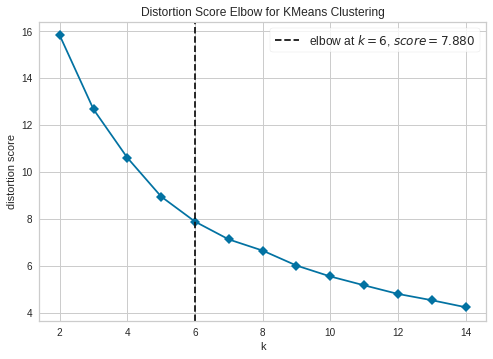

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
kms=KMeans(random_state=5)
visualizer = KElbowVisualizer(kms,timings=False, k=(2,15))
visualizer.fit(train_dt)
visualizer.show()

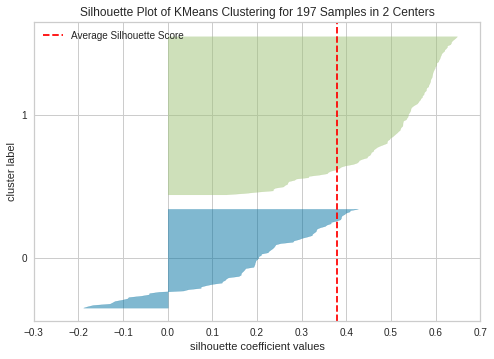

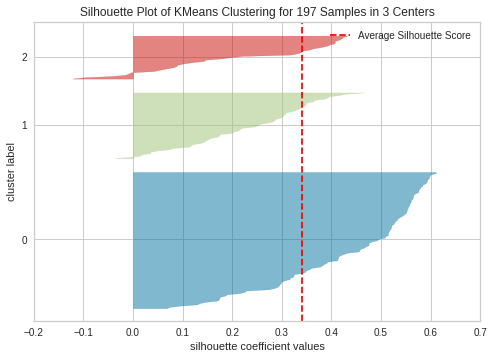

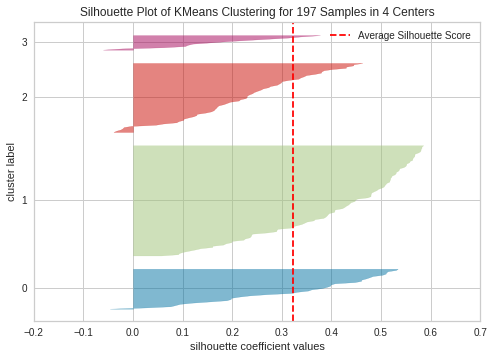

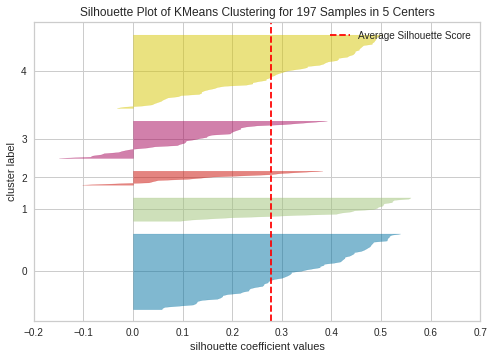

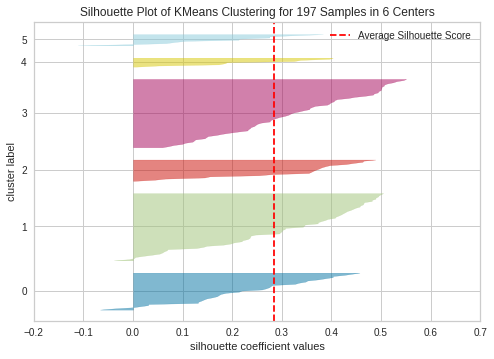

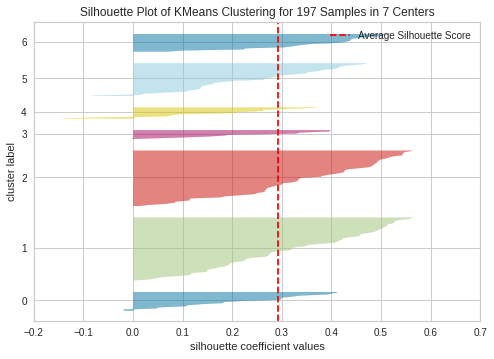

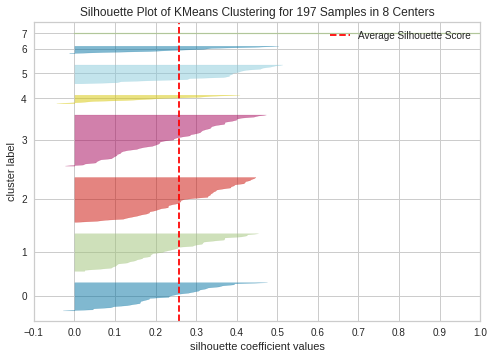

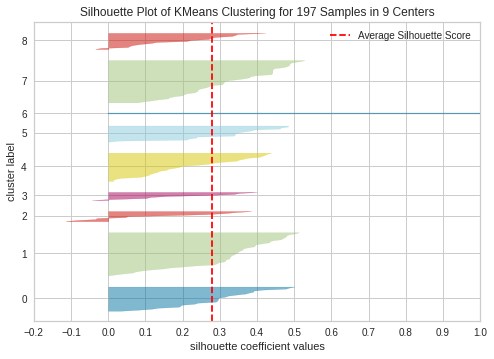

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

for k in range(2,10):
    kms=KMeans(n_clusters=k,random_state=5)
    visualizer = SilhouetteVisualizer(kms, colors='yellowbrick')
    visualizer.fit(train_dt)
    visualizer.show()


In [12]:
demogr_sf_res['clusters']=labels
demogr_sf_res

<ipython-input-12-829a0a98d95b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demogr_sf_res['clusters']=labels


tract_fips10  popden13_17  phispanic13_17  inc_above_100k  30-40_pop  \
0    06075010100   13232.0900        0.070078        0.430274   0.394505   
1    06075010200   21917.6300        0.030713        0.705506   0.366262   
2    06075010300   42257.9700        0.092529        0.510823   0.387252   
3    06075010400   35832.9800        0.117330        0.696329   0.435307   
4    06075010500   10194.5400        0.106652        0.635531   0.316983   
..           ...          ...             ...             ...        ...   
192  06075980401       0.0000        0.000000        0.000000   0.000000   
193  06075980501    1277.7750        0.187980        0.312500   0.148338   
194  06075980600     623.1144        0.173489        0.406250   0.249513   
195  06075980900     174.7661        0.239669        0.625000   0.632231   
196  06075990100       0.0000        0.000000        0.000000   0.000000   

     clusters  
0           0  
1           4  
2           0  
3           4  
4           0  
..        ...  
192         3  
193         3  
194         3  
195         4  
196         3  

[197 rows x 6 columns]

In [13]:
demogr_sf_res.groupby('clusters').mean()

popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                         
0         26327.241314        0.099019        0.548169   0.318769
1         31290.735190        0.408765        0.411027   0.353477
2         95456.044615        0.160267        0.312266   0.323124
3         22742.802739        0.189180        0.241370   0.251018
4         25981.377286        0.096635        0.771802   0.406341

In [14]:
demogr_sf_res.groupby('clusters').count()

tract_fips10  popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                                      
0                   66           66              66              66         66
1                   21           21              21              21         21
2                   13           13              13              13         13
3                   33           33              33              33         33
4                   64           64              64              64         64

In [15]:
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
ct=ColumnTransformer([('scaler',MinMaxScaler(),slice(1,5))])
train_dt=ct.fit_transform(demogr_sf_res)
from sklearn.cluster import KMeans
kms=KMeans(n_clusters=4,random_state=5).fit(train_dt)
labels4=kms.labels_
labels4[0:10]

array([2, 1, 2, 1, 1, 2, 3, 1, 1, 1], dtype=int32)

In [16]:
demogr_sf_res['clusters']=labels4
demogr_sf_res.groupby('clusters').mean()

<ipython-input-16-6dc9582ea4b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demogr_sf_res['clusters']=labels4


popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                         
0         29551.839353        0.363477        0.358752   0.321464
1         26503.060775        0.097830        0.727941   0.382303
2         23534.135743        0.106694        0.396605   0.287062
3         95456.044615        0.160267        0.312266   0.323124

In [17]:
demogr_sf_res.groupby('clusters').count()

tract_fips10  popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                                      
0                   34           34              34              34         34
1                   92           92              92              92         92
2                   58           58              58              58         58
3                   13           13              13              13         13

In [18]:
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
ct=ColumnTransformer([('scaler',MinMaxScaler(),slice(1,5))])
train_dt=ct.fit_transform(demogr_sf_res)
from sklearn.cluster import KMeans
kms=KMeans(n_clusters=6,random_state=5).fit(train_dt)
labels6=kms.labels_
labels6[0:10]


array([3, 1, 3, 1, 3, 5, 5, 3, 1, 3], dtype=int32)

In [19]:
demogr_sf_res['clusters']=labels6+1
demogr_sf_res.groupby('clusters').mean()

<ipython-input-19-5604ce678dd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demogr_sf_res['clusters']=labels6+1


popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                          
1          25974.421218        0.227688        0.320246   0.279741
2          26744.644546        0.101842        0.768782   0.416153
3          32147.740950        0.410287        0.418315   0.366709
4          25039.448963        0.083748        0.573469   0.308415
5         105580.566667        0.197924        0.366408   0.360659
6          35343.017181        0.045198        0.111594   0.213954

In [20]:
demogr_sf_res.groupby('clusters').count()

tract_fips10  popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                                      
1                   34           34              34              34         34
2                   61           61              61              61         61
3                   20           20              20              20         20
4                   62           62              62              62         62
5                    9            9               9               9          9
6                   11           11              11              11         11

In [21]:
demogr_sf_res.dtypes

tract_fips10       object
popden13_17       float64
phispanic13_17    float64
inc_above_100k    float64
30-40_pop         float64
clusters            int32
dtype: object

In [22]:
import geopandas as gpd

geosan = gpd.read_file(r'__San_Francisco_Bay_Region_2010_Census_Tracts_(clipped).geojson', driver='GeoJSON')
demogr_sf_res.rename(columns={'tract_fips10':'trctid'},inplace=True)
geosan=pd.merge(geosan,demogr_sf_res,how='right',on='trctid')

geosan

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


objectid fipst fipco       trctid              trctname  Shape__Area  \
0       664.0    06   075  06075010100      Census Tract 101     0.000079   
1       665.0    06   075  06075010200      Census Tract 102     0.000053   
2       666.0    06   075  06075010300      Census Tract 103     0.000027   
3       667.0    06   075  06075010400      Census Tract 104     0.000034   
4       668.0    06   075  06075010500      Census Tract 105     0.000070   
..        ...   ...   ...          ...                   ...          ...   
192     856.0    06   075  06075980401  Census Tract 9804.01     0.000043   
193     857.0    06   075  06075980501  Census Tract 9805.01     0.000162   
194     858.0    06   075  06075980600     Census Tract 9806     0.000218   
195     859.0    06   075  06075980900     Census Tract 9809     0.000367   
196       NaN   NaN   NaN  06075990100                   NaN          NaN   

     Shape__Length                                           geometry  \
0         0.214358  POLYGON ((-122.40060 37.80603, -122.40041 37.8...   
1         0.048540  MULTIPOLYGON (((-122.42663 37.80883, -122.4266...   
2         0.022957  POLYGON ((-122.41489 37.80355, -122.41546 37.8...   
3         0.032687  POLYGON ((-122.40243 37.79939, -122.40262 37.8...   
4         0.087869  POLYGON ((-122.39200 37.79388, -122.39169 37.7...   
..             ...                                                ...   
192       0.073780  MULTIPOLYGON (((-123.00361 37.69325, -123.0027...   
193       0.071783  POLYGON ((-122.40668 37.71922, -122.40697 37.7...   
194       0.188398  MULTIPOLYGON (((-122.38681 37.72431, -122.3867...   
195       0.132279  POLYGON ((-122.37413 37.74498, -122.37416 37.7...   
196            NaN                                               None   

     popden13_17  phispanic13_17  inc_above_100k  30-40_pop  clusters  
0     13232.0900        0.070078        0.430274   0.394505         4  
1     21917.6300        0.030713        0.705506   0.366262         2  
2     42257.9700        0.092529        0.510823   0.387252         4  
3     35832.9800        0.117330        0.696329   0.435307         2  
4     10194.5400        0.106652        0.635531   0.316983         4  
..           ...             ...             ...        ...       ...  
192       0.0000        0.000000        0.000000   0.000000         6  
193    1277.7750        0.187980        0.312500   0.148338         1  
194     623.1144        0.173489        0.406250   0.249513         1  
195     174.7661        0.239669        0.625000   0.632231         2  
196       0.0000        0.000000        0.000000   0.000000         6  

[197 rows x 13 columns]

In [23]:
#html template code for map legend
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Big</li>
    <li><span style='background:orange;opacity:0.7;'></span>Medium</li>
    <li><span style='background:green;opacity:0.7;'></span>Small</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [24]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res.set_index('trctid')['clusters']
step = cmp.StepColormap(
 ['purple','red','yellow','blue','green','cyan'],
 vmin=0, vmax=6,
 index=[0,1, 2, 3, 4 ,5,6],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.5,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)
#geosan=r'2010_sf_census_tracts_without_water_clippings.geojson'
#sanmap=folium.Map(zoom_start=12,location=[37.77,-122.42])
#sanmap.choropleth(geo_data=geosan,data=demogr_sf_res,columns=['trctid','clusters'],
                  #key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Clusters",fill_opacity=0.7,line_opacity=0.2)
step.add_to(sanmap) 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
sanmap

In [25]:
demogr_sf_res.groupby('clusters').mean()

popden13_17  phispanic13_17  inc_above_100k  30-40_pop
clusters                                                          
1          25974.421218        0.227688        0.320246   0.279741
2          26744.644546        0.101842        0.768782   0.416153
3          32147.740950        0.410287        0.418315   0.366709
4          25039.448963        0.083748        0.573469   0.308415
5         105580.566667        0.197924        0.366408   0.360659
6          35343.017181        0.045198        0.111594   0.213954

In [26]:
demogr_sf_res

trctid  popden13_17  phispanic13_17  inc_above_100k  30-40_pop  \
0    06075010100   13232.0900        0.070078        0.430274   0.394505   
1    06075010200   21917.6300        0.030713        0.705506   0.366262   
2    06075010300   42257.9700        0.092529        0.510823   0.387252   
3    06075010400   35832.9800        0.117330        0.696329   0.435307   
4    06075010500   10194.5400        0.106652        0.635531   0.316983   
..           ...          ...             ...             ...        ...   
192  06075980401       0.0000        0.000000        0.000000   0.000000   
193  06075980501    1277.7750        0.187980        0.312500   0.148338   
194  06075980600     623.1144        0.173489        0.406250   0.249513   
195  06075980900     174.7661        0.239669        0.625000   0.632231   
196  06075990100       0.0000        0.000000        0.000000   0.000000   

     clusters  
0           4  
1           2  
2           4  
3           2  
4           4  
..        ...  
192         6  
193         1  
194         1  
195         2  
196         6  

[197 rows x 6 columns]

In [27]:
demogr_sf_res_avg=pd.DataFrame()
demogr_sf_res_avg['trctid']=demogr_sf_res['trctid']
demogr_sf_res_avg['avg_hisp']=demogr_sf_res['popden13_17']*demogr_sf_res['phispanic13_17']
demogr_sf_res_avg['avg_inc_above_100k']=demogr_sf_res['popden13_17']*demogr_sf_res['inc_above_100k']
demogr_sf_res_avg['avg_30-40_pop']=demogr_sf_res['popden13_17']*demogr_sf_res['30-40_pop']
demogr_sf_res_avg

trctid     avg_hisp  avg_inc_above_100k  avg_30-40_pop
0    06075010100   927.280282         5693.425998    5220.121250
1    06075010200   673.152074        15463.014831    8027.589366
2    06075010300  3910.093326        21586.323342   16364.464002
3    06075010400  4204.300087        24951.551587   15598.339407
4    06075010500  1087.266095         6478.947501    3231.491081
..           ...          ...                 ...            ...
192  06075980401     0.000000            0.000000       0.000000
193  06075980501   240.195549          399.304688     189.542075
194  06075980600   108.103664          253.140225     155.474939
195  06075980900    41.886091          109.228813     110.492619
196  06075990100     0.000000            0.000000       0.000000

[197 rows x 4 columns]

In [28]:
train_data=demogr_sf_res_avg.iloc[:,1:]

In [29]:
train_data

avg_hisp  avg_inc_above_100k  avg_30-40_pop
0     927.280282         5693.425998    5220.121250
1     673.152074        15463.014831    8027.589366
2    3910.093326        21586.323342   16364.464002
3    4204.300087        24951.551587   15598.339407
4    1087.266095         6478.947501    3231.491081
..           ...                 ...            ...
192     0.000000            0.000000       0.000000
193   240.195549          399.304688     189.542075
194   108.103664          253.140225     155.474939
195    41.886091          109.228813     110.492619
196     0.000000            0.000000       0.000000

[197 rows x 3 columns]

In [30]:
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
ct=ColumnTransformer([('scaler',MinMaxScaler(),['avg_hisp','avg_inc_above_100k','avg_30-40_pop'])])
scaled_td=ct.fit_transform(train_data)
from sklearn.cluster import KMeans
kms=KMeans(n_clusters=6,random_state=5).fit(train_dt)
labels=kms.labels_
labels[0:10]

array([3, 1, 3, 1, 3, 5, 5, 3, 1, 3], dtype=int32)

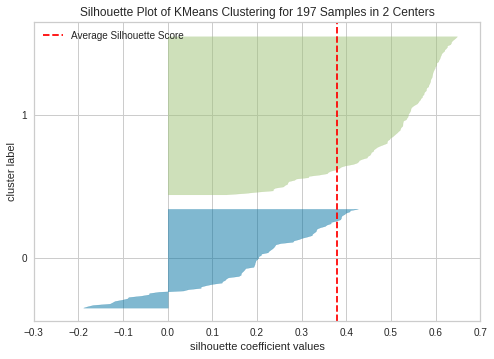

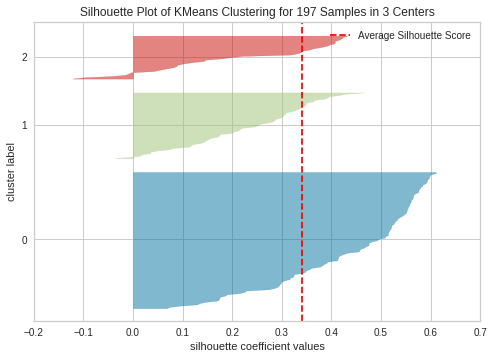

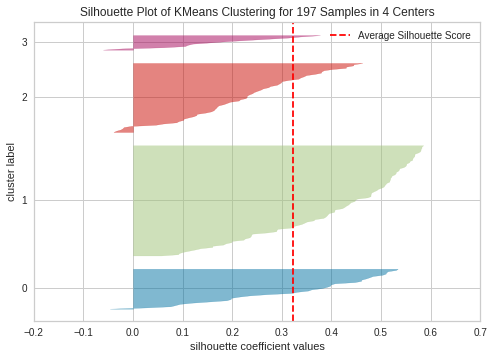

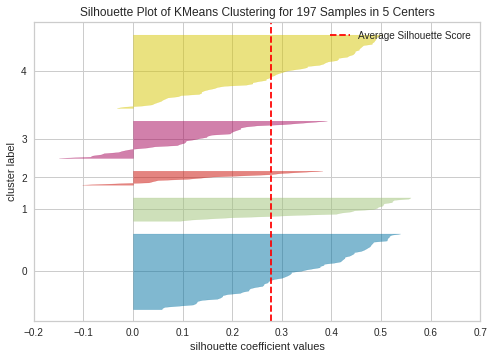

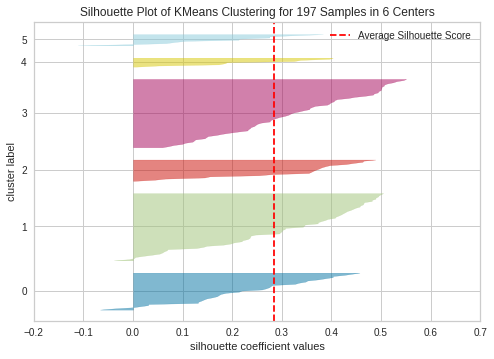

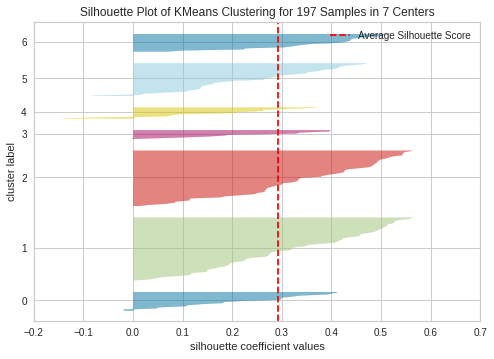

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer

for k in range(2,8):
    kms=KMeans(n_clusters=k,random_state=5)
    visualizer = SilhouetteVisualizer(kms, colors='yellowbrick')
    visualizer.fit(train_dt)
    visualizer.show()

In [32]:
demogr_sf_res_avg['clusters']=labels+1
demogr_sf_res_avg

trctid     avg_hisp  avg_inc_above_100k  avg_30-40_pop  clusters
0    06075010100   927.280282         5693.425998    5220.121250         4
1    06075010200   673.152074        15463.014831    8027.589366         2
2    06075010300  3910.093326        21586.323342   16364.464002         4
3    06075010400  4204.300087        24951.551587   15598.339407         2
4    06075010500  1087.266095         6478.947501    3231.491081         4
..           ...          ...                 ...            ...       ...
192  06075980401     0.000000            0.000000       0.000000         6
193  06075980501   240.195549          399.304688     189.542075         1
194  06075980600   108.103664          253.140225     155.474939         1
195  06075980900    41.886091          109.228813     110.492619         2
196  06075990100     0.000000            0.000000       0.000000         6

[197 rows x 5 columns]

In [33]:
demogr_sf_res_avg.describe()

avg_hisp  avg_inc_above_100k  avg_30-40_pop    clusters
count    197.000000          197.000000     197.000000  197.000000
mean    4944.686772        15457.786199   10577.024629    2.918782
std     6420.243833        10152.912164    8075.466483    1.415477
min        0.000000            0.000000       0.000000    1.000000
25%     1450.268496         9008.583807    5873.239622    2.000000
50%     2914.469614        13853.137914    9203.147634    3.000000
75%     5439.174669        20435.035732   13164.907394    4.000000
max    39646.417008        67092.308299   57851.690639    6.000000

In [34]:
demogr_sf_res_avg.groupby('clusters').mean()

avg_hisp  avg_inc_above_100k  avg_30-40_pop
clusters                                                 
1          5878.317414         8179.541338    7532.456383
2          2678.527139        20258.646155   11147.280667
3         13559.740974        13156.210962   11772.195552
4          2023.372709        14148.504236    7845.606987
5         22058.258896        35742.865060   37269.779641
6          1425.644455         6298.617536    8207.877571

In [35]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['clusters']
step = cmp.StepColormap(
 ['purple','red','yellow','blue','green','cyan'],
 vmin=0, vmax=6,
 index=[0,1, 2, 3, 4 ,5,6],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.5,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

step.add_to(sanmap) 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
sanmap

In [36]:
scaled_df=pd.DataFrame(scaled_td,columns=['avg_hisp','avg_inc_above_100k','avg_30-40_pop'])
scaled_df['tractid']=demogr_sf_res_avg['trctid']
scaled_df

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid
0    0.023389            0.084860       0.090233  06075010100
1    0.016979            0.230474       0.138762  06075010200
2    0.098624            0.321741       0.282869  06075010300
3    0.106045            0.371899       0.269626  06075010400
4    0.027424            0.096568       0.055858  06075010500
..        ...                 ...            ...          ...
192  0.000000            0.000000       0.000000  06075980401
193  0.006058            0.005952       0.003276  06075980501
194  0.002727            0.003773       0.002687  06075980600
195  0.001056            0.001628       0.001910  06075980900
196  0.000000            0.000000       0.000000  06075990100

[197 rows x 4 columns]

In [37]:
scaled_df['suitability']=scaled_df['avg_inc_above_100k']*0.45+scaled_df['avg_hisp']*0.35+scaled_df['avg_30-40_pop']*0.2
scaled_df['tractid']=demogr_sf_res_avg['trctid']
scaled_df['clusters']=demogr_sf_res_avg['clusters']
scaled_df

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid  suitability  \
0    0.023389            0.084860       0.090233  06075010100     0.064419   
1    0.016979            0.230474       0.138762  06075010200     0.137408   
2    0.098624            0.321741       0.282869  06075010300     0.235876   
3    0.106045            0.371899       0.269626  06075010400     0.258395   
4    0.027424            0.096568       0.055858  06075010500     0.064226   
..        ...                 ...            ...          ...          ...   
192  0.000000            0.000000       0.000000  06075980401     0.000000   
193  0.006058            0.005952       0.003276  06075980501     0.005454   
194  0.002727            0.003773       0.002687  06075980600     0.003190   
195  0.001056            0.001628       0.001910  06075980900     0.001484   
196  0.000000            0.000000       0.000000  06075990100     0.000000   

     clusters  
0           4  
1           2  
2           4  
3           2  
4           4  
..        ...  
192         6  
193         1  
194         1  
195         2  
196         6  

[197 rows x 6 columns]

In [38]:
pd.set_option('display.max_rows', 20)
scaled_df.sort_values(by='suitability',ascending=False).head(20)

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid  suitability  \
19  1.000000            0.728993       1.000000  06075012201     0.878047   
26  0.940281            0.483341       0.696258  06075012502     0.685854   
15  0.325094            1.000000       0.493014  06075011901     0.662386   
18  0.434127            0.721727       0.525000  06075012100     0.581722   
20  0.625221            0.385998       0.705433  06075012202     0.533613   
16  0.254139            0.656298       0.567238  06075011902     0.497730   
23  0.888607            0.038151       0.837276  06075012401     0.495635   
95  0.873476            0.231428       0.335591  06075022901     0.476977   
34  0.115946            0.594821       0.474682  06075013101     0.403187   
48  0.149206            0.589304       0.377811  06075015802     0.392971   
78  0.426771            0.331271       0.353139  06075020800     0.369070   
94  0.501394            0.282405       0.328057  06075022803     0.368182   
22  0.310954            0.356687       0.492402  06075012302     0.367824   
17  0.228947            0.423479       0.481446  06075012000     0.366986   
96  0.454089            0.329904       0.259235  06075022902     0.359235   
10  0.082106            0.546408       0.385347  06075011100     0.351690   
7   0.156618            0.493542       0.362593  06075010800     0.349429   
53  0.127005            0.516855       0.347060  06075016300     0.346448   
9   0.077052            0.518150       0.313842  06075011000     0.322904   
80  0.199904            0.397765       0.311109  06075021000     0.311183   

    clusters  
19         5  
26         5  
15         5  
18         5  
20         5  
16         5  
23         5  
95         3  
34         2  
48         2  
78         3  
94         3  
22         5  
17         5  
96         3  
10         2  
7          4  
53         2  
9          4  
80         2

In [39]:
scaled_df.groupby('clusters').mean()

avg_hisp  avg_inc_above_100k  avg_30-40_pop  suitability
clusters                                                          
1         0.148269            0.121915       0.130203     0.132796
2         0.067560            0.301952       0.192687     0.198062
3         0.342017            0.196091       0.203489     0.248645
4         0.051035            0.210881       0.135616     0.139882
5         0.556375            0.532742       0.644230     0.563311
6         0.035959            0.093880       0.141878     0.083207

In [40]:
scaled_df.describe()

avg_hisp  avg_inc_above_100k  avg_30-40_pop  suitability    clusters
count  197.000000          197.000000     197.000000   197.000000  197.000000
mean     0.124720            0.230396       0.182830     0.183896    2.918782
std      0.161938            0.151328       0.139589     0.125124    1.415477
min      0.000000            0.000000       0.000000     0.000000    1.000000
25%      0.036580            0.134271       0.101522     0.106163    2.000000
50%      0.073512            0.206479       0.159082     0.164254    3.000000
75%      0.137192            0.304581       0.227563     0.235876    4.000000
max      1.000000            1.000000       1.000000     0.878047    6.000000

In [41]:
scaled_df

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid  suitability  \
0    0.023389            0.084860       0.090233  06075010100     0.064419   
1    0.016979            0.230474       0.138762  06075010200     0.137408   
2    0.098624            0.321741       0.282869  06075010300     0.235876   
3    0.106045            0.371899       0.269626  06075010400     0.258395   
4    0.027424            0.096568       0.055858  06075010500     0.064226   
..        ...                 ...            ...          ...          ...   
192  0.000000            0.000000       0.000000  06075980401     0.000000   
193  0.006058            0.005952       0.003276  06075980501     0.005454   
194  0.002727            0.003773       0.002687  06075980600     0.003190   
195  0.001056            0.001628       0.001910  06075980900     0.001484   
196  0.000000            0.000000       0.000000  06075990100     0.000000   

     clusters  
0           4  
1           2  
2           4  
3           2  
4           4  
..        ...  
192         6  
193         1  
194         1  
195         2  
196         6  

[197 rows x 6 columns]

In [42]:
import folium

sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
sanmap.choropleth(geo_data=geosan,data=scaled_df,columns=['tractid','suitability'],
                  key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Suitability",fill_opacity=0.7,line_opacity=0.2)

sanmap

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [43]:
scaled_df_5_3=scaled_df[(scaled_df['clusters']==3) |  (scaled_df['clusters']==5) ]
scaled_df_5_3

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid  suitability  \
15   0.325094            1.000000       0.493014  06075011901     0.662386   
16   0.254139            0.656298       0.567238  06075011902     0.497730   
17   0.228947            0.423479       0.481446  06075012000     0.366986   
18   0.434127            0.721727       0.525000  06075012100     0.581722   
19   1.000000            0.728993       1.000000  06075012201     0.878047   
..        ...                 ...            ...          ...          ...   
117  0.413814            0.134888       0.204450  06075026001     0.246425   
119  0.372751            0.182389       0.177661  06075026003     0.248070   
120  0.378991            0.242720       0.185633  06075026004     0.278997   
127  0.259468            0.233601       0.172137  06075026402     0.230362   
187  0.251651            0.108366       0.129965  06075061200     0.162835   

     clusters  
15          5  
16          5  
17          5  
18          5  
19          5  
..        ...  
117         3  
119         3  
120         3  
127         3  
187         3  

[29 rows x 6 columns]

In [44]:
scaled_df_5=scaled_df[(scaled_df['clusters']==5) ]
scaled_df_5

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid  suitability  \
15  0.325094            1.000000       0.493014  06075011901     0.662386   
16  0.254139            0.656298       0.567238  06075011902     0.497730   
17  0.228947            0.423479       0.481446  06075012000     0.366986   
18  0.434127            0.721727       0.525000  06075012100     0.581722   
19  1.000000            0.728993       1.000000  06075012201     0.878047   
20  0.625221            0.385998       0.705433  06075012202     0.533613   
22  0.310954            0.356687       0.492402  06075012302     0.367824   
23  0.888607            0.038151       0.837276  06075012401     0.495635   
26  0.940281            0.483341       0.696258  06075012502     0.685854   

    clusters  
15         5  
16         5  
17         5  
18         5  
19         5  
20         5  
22         5  
23         5  
26         5

In [45]:
import folium

sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
sanmap.choropleth(geo_data=geosan,data=scaled_df_5_3,columns=['tractid','suitability'],
                  key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Suitability",fill_opacity=0.7,line_opacity=0.2)

sanmap

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [46]:
cluster_5_dem=demogr_sf_res_avg[demogr_sf_res_avg['clusters']==5]
cluster_5_dem

trctid      avg_hisp  avg_inc_above_100k  avg_30-40_pop  clusters
15  06075011901  12888.822728        67092.308299   28521.716668         5
16  06075011902  10075.717382        44032.553789   32815.663272         5
17  06075012000   9076.916256        28412.188612   27852.455887         5
18  06075012100  17211.593520        48422.326451   30372.166392         5
19  06075012201  39646.417008        48909.843114   57851.690639         5
20  06075012202  24787.780445        25897.493424   40810.512473         5
22  06075012302  12328.217705        23930.965030   28486.288442         5
23  06075012401  35230.077797         2559.619177   48437.835591         5
26  06075012502  37278.787221        32428.487648   40279.687407         5

In [47]:
sf_tracts.rename(columns={'GEOID':'trctid'},inplace=True)
sf_tracts

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


trctid    ALAND     AWATER  ALAND_SQMI  AWATER_SQMI        Lat  \
0    06075010100   776490     646917       0.300        0.250  37.808520   
1    06075010200   515957     295388       0.199        0.114  37.805861   
2    06075010300   268266          0       0.104        0.000  37.801620   
3    06075010400   335744          0       0.130        0.000  37.802273   
4    06075010500   683605     494314       0.264        0.191  37.802684   
..           ...      ...        ...         ...          ...        ...   
192  06075980401   419323  247501289       0.162       95.561  37.727239   
193  06075980501  1577311       9769       0.609        0.004  37.716208   
194  06075980600  2132298    2016110       0.823        0.778  37.723166   
195  06075980900  3585240     260707       1.384        0.101  37.746286   
196  06075990100        0   70939179       0.000       27.390  37.762160   

            Lon  
0   -122.409554  
1   -122.422925  
2   -122.415681  
3   -122.407558  
4   -122.399050  
..          ...  
192 -123.032229  
193 -122.419346  
194 -122.368542  
195 -122.389477  
196 -122.551862  

[197 rows x 7 columns]

In [48]:
cluster_5_dem=pd.merge(cluster_5_dem,sf_tracts,how='left',on='trctid')
cluster_5_dem

trctid      avg_hisp  avg_inc_above_100k  avg_30-40_pop  clusters  \
0  06075011901  12888.822728        67092.308299   28521.716668         5   
1  06075011902  10075.717382        44032.553789   32815.663272         5   
2  06075012000   9076.916256        28412.188612   27852.455887         5   
3  06075012100  17211.593520        48422.326451   30372.166392         5   
4  06075012201  39646.417008        48909.843114   57851.690639         5   
5  06075012202  24787.780445        25897.493424   40810.512473         5   
6  06075012302  12328.217705        23930.965030   28486.288442         5   
7  06075012401  35230.077797         2559.619177   48437.835591         5   
8  06075012502  37278.787221        32428.487648   40279.687407         5   

    ALAND  AWATER  ALAND_SQMI  AWATER_SQMI        Lat         Lon  
0   62294       0       0.024          0.0  37.790473 -122.413914  
1   93053       0       0.036          0.0  37.790996 -122.409807  
2  125229       0       0.048          0.0  37.787965 -122.418527  
3  123394       0       0.048          0.0  37.788807 -122.411888  
4   92048       0       0.036          0.0  37.785846 -122.416353  
5   92823       0       0.036          0.0  37.785412 -122.419644  
6   92649       0       0.036          0.0  37.787022 -122.412097  
7   91972       0       0.036          0.0  37.783051 -122.415789  
8   61275       0       0.024          0.0  37.783933 -122.412595

In [49]:
cluster_5_dem.describe()

avg_hisp  avg_inc_above_100k  avg_30-40_pop  clusters  \
count      9.000000            9.000000       9.000000       9.0   
mean   22058.258896        35742.865060   37269.779641       5.0   
std    12431.280473        18667.982717   10486.404288       0.0   
min     9076.916256         2559.619177   27852.455887       5.0   
25%    12328.217705        25897.493424   28521.716668       5.0   
50%    17211.593520        32428.487648   32815.663272       5.0   
75%    35230.077797        48422.326451   40810.512473       5.0   
max    39646.417008        67092.308299   57851.690639       5.0   

               ALAND  AWATER  ALAND_SQMI  AWATER_SQMI        Lat         Lon  
count       9.000000     9.0    9.000000          9.0   9.000000    9.000000  
mean    92748.555556     0.0    0.036000          0.0  37.787056 -122.414513  
std     22117.270249     0.0    0.008485          0.0   0.002762    0.003286  
min     61275.000000     0.0    0.024000          0.0  37.783051 -122.419644  
25%     91972.000000     0.0    0.036000          0.0  37.785412 -122.416353  
50%     92649.000000     0.0    0.036000          0.0  37.787022 -122.413914  
75%     93053.000000     0.0    0.036000          0.0  37.788807 -122.412097  
max    125229.000000     0.0    0.048000          0.0  37.790996 -122.409807

In [50]:
np.sqrt(92748)

304.54556309360345

In [51]:
CLIENT_ID = 'NPXXRWCGISTUUNNXTE3AUJZYCM2XIG35323D53ZV5KKYF1WN' # your Foursquare ID
CLIENT_SECRET = 'PSPDQ53USDBYGO3RPU3AQFOOAPR3AV1ZEZD5V0AYKWQIFY1X' # your Foursquare Secret
ACCESS_TOKEN = 'CHNHAAHNI14LXTLD3TMYWX0CIXT0R1VCVY35S02HUFKCNBXW' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

In [63]:
def getNearbyVenues(names,categories, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                       CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            categories,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id'],
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list],columns = [
                  'trctid', 
                  'Tract Latitude', 
                  'Tract Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Category ID'
    ])
       
    return(nearby_venues)

In [90]:
import requests
names= cluster_5_dem.loc[:,'trctid']
longitudes= cluster_5_dem['Lon']
latitudes= cluster_5_dem['Lat']

food_cat='4d4b7105d754a06374d81259' #Foursquare Foof category

cl5_venues= getNearbyVenues(names,food_cat,latitudes, longitudes)
cl5_venues

06075011901
06075011902
06075012000
06075012100
06075012201
06075012202
06075012302
06075012401
06075012502


trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
860  06075012502       37.783933      -122.412595  4d24b237daa937040cc5c781   
861  06075012502       37.783933      -122.412595  49c2be75f964a52026561fe3   
862  06075012502       37.783933      -122.412595  4bcdc820b6c49c74cde19591   
863  06075012502       37.783933      -122.412595  5bbcefe5a6031c002c147a3a   
864  06075012502       37.783933      -122.412595  4e2b2cade4cd3bc166929328   

                               Venue  Venue Latitude  Venue Longitude  \
0                 Gusto Pinsa Romana       37.789594      -122.413873   
1                   Big 4 Restaurant       37.791490      -122.412393   
2                Liholiho Yacht Club       37.788332      -122.414605   
3                         Del Popolo       37.789807      -122.411347   
4                             Chisme       37.788467      -122.414802   
..                               ...             ...              ...   
860                  Pinecrest Diner       37.786997      -122.410027   
861               Boudin Bakery Café       37.786647      -122.407307   
862                    Daniel's Café       37.785283      -122.408879   
863                     Bi-Rite Cafe       37.778779      -122.417164   
864  Jasper's Corner Tap and Kitchen       37.786152      -122.411679   

          Venue Category         Venue Category ID  
0     Italian Restaurant  4bf58dd8d48988d110941735  
1    American Restaurant  4bf58dd8d48988d14e941735  
2    Hawaiian Restaurant  52e81612bcbc57f1066b79fe  
3            Pizza Place  4bf58dd8d48988d1ca941735  
4     Mexican Restaurant  4bf58dd8d48988d1c1941735  
..                   ...                       ...  
860                Diner  4bf58dd8d48988d147941735  
861               Bakery  4bf58dd8d48988d16a941735  
862                 Café  4bf58dd8d48988d16d941735  
863                 Café  4bf58dd8d48988d16d941735  
864            Gastropub  4bf58dd8d48988d155941735  

[865 rows x 9 columns]

In [65]:
#cl5_venues.rename(columns={'Neighborhood':'trctid'},inplace=True)
cl5_venues

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
860  06075012502       37.783933      -122.412595  4d24b237daa937040cc5c781   
861  06075012502       37.783933      -122.412595  49c2be75f964a52026561fe3   
862  06075012502       37.783933      -122.412595  4bcdc820b6c49c74cde19591   
863  06075012502       37.783933      -122.412595  5bbcefe5a6031c002c147a3a   
864  06075012502       37.783933      -122.412595  4e2b2cade4cd3bc166929328   

                               Venue  Venue Latitude  Venue Longitude  \
0                 Gusto Pinsa Romana       37.789594      -122.413873   
1                   Big 4 Restaurant       37.791490      -122.412393   
2                Liholiho Yacht Club       37.788332      -122.414605   
3                         Del Popolo       37.789807      -122.411347   
4                             Chisme       37.788467      -122.414802   
..                               ...             ...              ...   
860                  Pinecrest Diner       37.786997      -122.410027   
861               Boudin Bakery Café       37.786647      -122.407307   
862                    Daniel's Café       37.785283      -122.408879   
863                     Bi-Rite Cafe       37.778779      -122.417164   
864  Jasper's Corner Tap and Kitchen       37.786152      -122.411679   

          Venue Category         Venue Category ID  
0     Italian Restaurant  4bf58dd8d48988d110941735  
1    American Restaurant  4bf58dd8d48988d14e941735  
2    Hawaiian Restaurant  52e81612bcbc57f1066b79fe  
3            Pizza Place  4bf58dd8d48988d1ca941735  
4     Mexican Restaurant  4bf58dd8d48988d1c1941735  
..                   ...                       ...  
860                Diner  4bf58dd8d48988d147941735  
861               Bakery  4bf58dd8d48988d16a941735  
862                 Café  4bf58dd8d48988d16d941735  
863                 Café  4bf58dd8d48988d16d941735  
864            Gastropub  4bf58dd8d48988d155941735  

[865 rows x 9 columns]

In [91]:
cl5_venues.drop_duplicates(subset='Venue Id',ignore_index=True,inplace=True)
cl5_venues

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
272  06075012401       37.783051      -122.415789  59a24aa726659b0902fb4d04   
273  06075012502       37.783933      -122.412595  5851bb0176b8b2224d9941d4   
274  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
275  06075012502       37.783933      -122.412595  4b91310cf964a520efa833e3   
276  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   

                     Venue  Venue Latitude  Venue Longitude  \
0       Gusto Pinsa Romana       37.789594      -122.413873   
1         Big 4 Restaurant       37.791490      -122.412393   
2      Liholiho Yacht Club       37.788332      -122.414605   
3               Del Popolo       37.789807      -122.411347   
4                   Chisme       37.788467      -122.414802   
..                     ...             ...              ...   
272              Oma Sushi       37.786124      -122.410247   
273  Frena Bakery and Cafe       37.780500      -122.408250   
274            Box Kitchen       37.781158      -122.406243   
275   Java Trading Company       37.782599      -122.406298   
276                    Tín       37.780840      -122.405770   

            Venue Category         Venue Category ID  
0       Italian Restaurant  4bf58dd8d48988d110941735  
1      American Restaurant  4bf58dd8d48988d14e941735  
2      Hawaiian Restaurant  52e81612bcbc57f1066b79fe  
3              Pizza Place  4bf58dd8d48988d1ca941735  
4       Mexican Restaurant  4bf58dd8d48988d1c1941735  
..                     ...                       ...  
272       Sushi Restaurant  4bf58dd8d48988d1d2941735  
273                 Bakery  4bf58dd8d48988d16a941735  
274    American Restaurant  4bf58dd8d48988d14e941735  
275                   Café  4bf58dd8d48988d16d941735  
276  Vietnamese Restaurant  4bf58dd8d48988d14a941735  

[277 rows x 9 columns]

In [92]:
cl5_venues['Venue Category'].unique()

array(['Italian Restaurant', 'American Restaurant', 'Hawaiian Restaurant',
       'Pizza Place', 'Mexican Restaurant', 'Sandwich Place',
       'Vietnamese Restaurant', 'French Restaurant', 'Sushi Restaurant',
       'Burger Joint', 'Café', 'Korean Restaurant', 'Japanese Restaurant',
       'Filipino Restaurant', 'Diner', 'Breakfast Spot', 'Deli / Bodega',
       'Gastropub', 'Thai Restaurant', 'Wings Joint', 'Bakery',
       'Seafood Restaurant', 'Donut Shop', 'Ramen Restaurant',
       'Hotpot Restaurant', 'North Indian Restaurant',
       'Ethiopian Restaurant', 'Steakhouse', 'Mediterranean Restaurant',
       'Indian Restaurant', 'Moroccan Restaurant', 'Turkish Restaurant',
       'Middle Eastern Restaurant', 'Chinese Restaurant',
       'Asian Restaurant', 'Restaurant', 'Russian Restaurant',
       'Japanese Curry Restaurant', 'Southern / Soul Food Restaurant',
       'Latin American Restaurant', 'Dim Sum Restaurant', 'Salad Place',
       'Cantonese Restaurant', 'Irish Pub', 'Sze

In [94]:
other_food_cat=['Sandwich Place','Café','Breakfast Spot','Bakery','Donut Shop','Irish Pub','Wagashi Place', 'Bagel Shop', 'Food Truck','Fast Food Restaurant']
cl5_res=cl5_venues.drop(index=cl5_venues[cl5_venues['Venue Category'].isin(other_food_cat)].index)
cl5_res

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
269  06075012401       37.783051      -122.415789  4a2c0803f964a5200e971fe3   
270  06075012401       37.783051      -122.415789  5c40381f603d2a002c295ff9   
272  06075012401       37.783051      -122.415789  59a24aa726659b0902fb4d04   
274  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
276  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   

                   Venue  Venue Latitude  Venue Longitude  \
0     Gusto Pinsa Romana       37.789594      -122.413873   
1       Big 4 Restaurant       37.791490      -122.412393   
2    Liholiho Yacht Club       37.788332      -122.414605   
3             Del Popolo       37.789807      -122.411347   
4                 Chisme       37.788467      -122.414802   
..                   ...             ...              ...   
269          Sam's Diner       37.778375      -122.415426   
270        The Pawn Shop       37.781060      -122.408548   
272            Oma Sushi       37.786124      -122.410247   
274          Box Kitchen       37.781158      -122.406243   
276                  Tín       37.780840      -122.405770   

            Venue Category         Venue Category ID  
0       Italian Restaurant  4bf58dd8d48988d110941735  
1      American Restaurant  4bf58dd8d48988d14e941735  
2      Hawaiian Restaurant  52e81612bcbc57f1066b79fe  
3              Pizza Place  4bf58dd8d48988d1ca941735  
4       Mexican Restaurant  4bf58dd8d48988d1c1941735  
..                     ...                       ...  
269                  Diner  4bf58dd8d48988d147941735  
270       Tapas Restaurant  4bf58dd8d48988d1db931735  
272       Sushi Restaurant  4bf58dd8d48988d1d2941735  
274    American Restaurant  4bf58dd8d48988d14e941735  
276  Vietnamese Restaurant  4bf58dd8d48988d14a941735  

[215 rows x 9 columns]

In [69]:

mex_categories=['4bf58dd8d48988d1c1941735','58daa1558bbb0b01f18ec1d9',
            '4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
            '56aa371ae4b08b9a8d5734ba','5744ccdfe4b0c0459246b4d3'
             ] #Foursquare Mexican Restaurants categories
mex_venues=cl5_venues[cl5_venues['Venue Category ID'].isin(mex_categories)].reset_index()
mex_venues

index       trctid  Tract Latitude  Tract Longitude  \
0       4  06075011901       37.790473      -122.413914   
1      62  06075011901       37.790473      -122.413914   
2      73  06075011901       37.790473      -122.413914   
3     177  06075012000       37.787965      -122.418527   
4     190  06075012100       37.788807      -122.411888   
5     205  06075012100       37.788807      -122.411888   
6     213  06075012201       37.785846      -122.416353   
7     216  06075012201       37.785846      -122.416353   
8     231  06075012201       37.785846      -122.416353   
9     239  06075012202       37.785412      -122.419644   
10    244  06075012202       37.785412      -122.419644   

                    Venue Id                       Venue  Venue Latitude  \
0   59cb288d6c08d172265a8e6d                      Chisme       37.788467   
1   55ee12f4498e5acd582cd338          El Rincón Yucateco       37.785824   
2   49fa3c25f964a520dc6d1fe3  Pancho's Salsa Bar & Grill       37.791985   
3   56b28aa9498ec9031e9f4b0a                     Matador       37.788898   
4   4a846e6cf964a52094fc1fe3        Taqueria Castillo B2       37.783778   
5   4a7b2e4ff964a52037ea1fe3             Taqueria La Paz       37.783328   
6   51b28827498ef0351235c618               El Castillito       37.781961   
7   49e4f160f964a52074631fe3             Taqueria Cancun       37.781875   
8   4550e681f964a520e43c1fe3      Colibrí Mexican Bistro       37.787109   
9   4b524b07f964a5205f7527e3      Taqueria El Castillito       37.781569   
10  568ed7e8498ec5e165503bbe          Taqueria Catillito       37.781752   

    Venue Longitude      Venue Category         Venue Category ID  
0       -122.414802  Mexican Restaurant  4bf58dd8d48988d1c1941735  
1       -122.412842  Mexican Restaurant  4bf58dd8d48988d1c1941735  
2       -122.421047  Mexican Restaurant  4bf58dd8d48988d1c1941735  
3       -122.411570          Taco Place  4bf58dd8d48988d151941735  
4       -122.409030       Burrito Place  4bf58dd8d48988d153941735  
5       -122.413703          Taco Place  4bf58dd8d48988d151941735  
6       -122.414737  Mexican Restaurant  4bf58dd8d48988d1c1941735  
7       -122.410322       Burrito Place  4bf58dd8d48988d153941735  
8       -122.410533  Mexican Restaurant  4bf58dd8d48988d1c1941735  
9       -122.416897       Burrito Place  4bf58dd8d48988d153941735  
10      -122.416873          Taco Place  4bf58dd8d48988d151941735

In [98]:
import geopandas
geometry=geopandas.points_from_xy(cl5_res['Venue Longitude'],cl5_res['Venue Latitude'])
cl5_res=geopandas.GeoDataFrame(cl5_res,geometry=geometry)
cl5_res

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
269  06075012401       37.783051      -122.415789  4a2c0803f964a5200e971fe3   
270  06075012401       37.783051      -122.415789  5c40381f603d2a002c295ff9   
272  06075012401       37.783051      -122.415789  59a24aa726659b0902fb4d04   
274  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
276  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   

                   Venue  Venue Latitude  Venue Longitude  \
0     Gusto Pinsa Romana       37.789594      -122.413873   
1       Big 4 Restaurant       37.791490      -122.412393   
2    Liholiho Yacht Club       37.788332      -122.414605   
3             Del Popolo       37.789807      -122.411347   
4                 Chisme       37.788467      -122.414802   
..                   ...             ...              ...   
269          Sam's Diner       37.778375      -122.415426   
270        The Pawn Shop       37.781060      -122.408548   
272            Oma Sushi       37.786124      -122.410247   
274          Box Kitchen       37.781158      -122.406243   
276                  Tín       37.780840      -122.405770   

            Venue Category         Venue Category ID  \
0       Italian Restaurant  4bf58dd8d48988d110941735   
1      American Restaurant  4bf58dd8d48988d14e941735   
2      Hawaiian Restaurant  52e81612bcbc57f1066b79fe   
3              Pizza Place  4bf58dd8d48988d1ca941735   
4       Mexican Restaurant  4bf58dd8d48988d1c1941735   
..                     ...                       ...   
269                  Diner  4bf58dd8d48988d147941735   
270       Tapas Restaurant  4bf58dd8d48988d1db931735   
272       Sushi Restaurant  4bf58dd8d48988d1d2941735   
274    American Restaurant  4bf58dd8d48988d14e941735   
276  Vietnamese Restaurant  4bf58dd8d48988d14a941735   

                        geometry  
0    POINT (-122.41387 37.78959)  
1    POINT (-122.41239 37.79149)  
2    POINT (-122.41461 37.78833)  
3    POINT (-122.41135 37.78981)  
4    POINT (-122.41480 37.78847)  
..                           ...  
269  POINT (-122.41543 37.77837)  
270  POINT (-122.40855 37.78106)  
272  POINT (-122.41025 37.78612)  
274  POINT (-122.40624 37.78116)  
276  POINT (-122.40577 37.78084)  

[215 rows x 10 columns]

In [115]:
def add_color(venue):
    if venue=='Mexican Restaurant':
        color='red'
    elif venue=='Taco Place':
        color='purple'
    elif venue=='Burrito Place':
        color='orange'
    else:
        color='blue'
    return color
cl5_res['color']=cl5_res.apply(lambda x: add_color(x["Venue Category"]),axis=1)
cl5_res
                                                 
    


trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
269  06075012401       37.783051      -122.415789  4a2c0803f964a5200e971fe3   
270  06075012401       37.783051      -122.415789  5c40381f603d2a002c295ff9   
272  06075012401       37.783051      -122.415789  59a24aa726659b0902fb4d04   
274  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
276  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   

                   Venue  Venue Latitude  Venue Longitude  \
0     Gusto Pinsa Romana       37.789594      -122.413873   
1       Big 4 Restaurant       37.791490      -122.412393   
2    Liholiho Yacht Club       37.788332      -122.414605   
3             Del Popolo       37.789807      -122.411347   
4                 Chisme       37.788467      -122.414802   
..                   ...             ...              ...   
269          Sam's Diner       37.778375      -122.415426   
270        The Pawn Shop       37.781060      -122.408548   
272            Oma Sushi       37.786124      -122.410247   
274          Box Kitchen       37.781158      -122.406243   
276                  Tín       37.780840      -122.405770   

            Venue Category         Venue Category ID  \
0       Italian Restaurant  4bf58dd8d48988d110941735   
1      American Restaurant  4bf58dd8d48988d14e941735   
2      Hawaiian Restaurant  52e81612bcbc57f1066b79fe   
3              Pizza Place  4bf58dd8d48988d1ca941735   
4       Mexican Restaurant  4bf58dd8d48988d1c1941735   
..                     ...                       ...   
269                  Diner  4bf58dd8d48988d147941735   
270       Tapas Restaurant  4bf58dd8d48988d1db931735   
272       Sushi Restaurant  4bf58dd8d48988d1d2941735   
274    American Restaurant  4bf58dd8d48988d14e941735   
276  Vietnamese Restaurant  4bf58dd8d48988d14a941735   

                        geometry color  
0    POINT (-122.41387 37.78959)  blue  
1    POINT (-122.41239 37.79149)  blue  
2    POINT (-122.41461 37.78833)  blue  
3    POINT (-122.41135 37.78981)  blue  
4    POINT (-122.41480 37.78847)   red  
..                           ...   ...  
269  POINT (-122.41543 37.77837)  blue  
270  POINT (-122.40855 37.78106)  blue  
272  POINT (-122.41025 37.78612)  blue  
274  POINT (-122.40624 37.78116)  blue  
276  POINT (-122.40577 37.78084)  blue  

[215 rows x 11 columns]

In [91]:
import json
print(json.dumps(results, indent=4, sort_keys=True))

{
    "groups": [
        {
            "items": [
                {
                    "reasons": {
                        "count": 0,
                        "items": [
                            {
                                "reasonName": "globalInteractionReason",
                                "summary": "This spot is popular",
                                "type": "general"
                            }
                        ]
                    },
                    "referralId": "e-0-5c0dd1ad5a2c91002c442f28-0",
                    "venue": {
                        "categories": [
                            {
                                "icon": {
                                    "prefix": "https://ss3.4sqi.net/img/categories_v2/food/italian_",
                                    "suffix": ".png"
                                },
                                "id": "4bf58dd8d48988d110941735",
                                "name": "Italian Restaurant",

In [147]:
import folium

sanmap=folium.Map(zoom_start=15.5,location=[37.78646,-122.414462])
folium.Choropleth(geo_data=geosan[geosan['clusters']==5],data=scaled_df_5_3,columns=['tractid','suitability'],
                  key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Suitability",fill_opacity=0.6,line_opacity=0.2).add_to(sanmap)
for i in range(0,len(cl5_res)):
    folium.Marker(location=[cl5_res.iloc[i]['Venue Latitude'],cl5_res.iloc[i]['Venue Longitude']],
                  popup=cl5_res.iloc[i]['Venue Category']+ '<br>' +cl5_res.iloc[i]['Venue'],icon = folium.Icon(color = "%s" % cl5_res.iloc[i]['color'])).add_to(sanmap)
    
#sanmap.GeoJson(cl5_res,name='CLuster 5 restaurants',tooltip=folium.GeoJsonTooltip(fields=['Venue Category','Venue']))
sanmap

In [150]:
cl5_res.to_feather("cl5_res.fea")

<ipython-input-150-654375261605>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  cl5_res.to_feather("cl5_res.fea")
